# Melanoma Detection Assignment
## Detection with CNN Model

### Necessary Imports

In [79]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from PIL import Image
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.regularizers import l2
from glob import glob

### Importing Skin Cancer Data - Data Collection

In [2]:
data_dir_train = pathlib.Path('Skin cancer ISIC The International Skin Imaging Collaboration/Train')
data_dir_test = pathlib.Path('Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [3]:
print(data_dir_train)

Skin cancer ISIC The International Skin Imaging Collaboration/Train


### Total number of images under Train and Test dataset

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### CNN input specific information

In [5]:
batch_size = 32
img_height = 180
img_width = 180

### Preparing Dataset for the training
Use 80% of the images for training, and 20% for validation.
seed = 123

#### 1. Create training dataset

In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(directory=data_dir_train, seed=123, 
                                                               batch_size=batch_size, 
                                                               image_size=(img_width, img_height), 
                                                               validation_split=0.2, 
                                                               subset="training")

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


#### 2. Create validation dataset

In [7]:
valid_ds = tf.keras.preprocessing.image_dataset_from_directory(directory=data_dir_test, seed=123, 
                                                               batch_size=batch_size, 
                                                               image_size=(img_width, img_height), 
                                                               validation_split=0.2, 
                                                               subset="validation")

Found 118 files belonging to 9 classes.
Using 23 files for validation.


### Visualization of one instance of each class
Number of classes = 9

- ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']

#### Class names present in the dataset

In [8]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


#### Drawing the images from each class

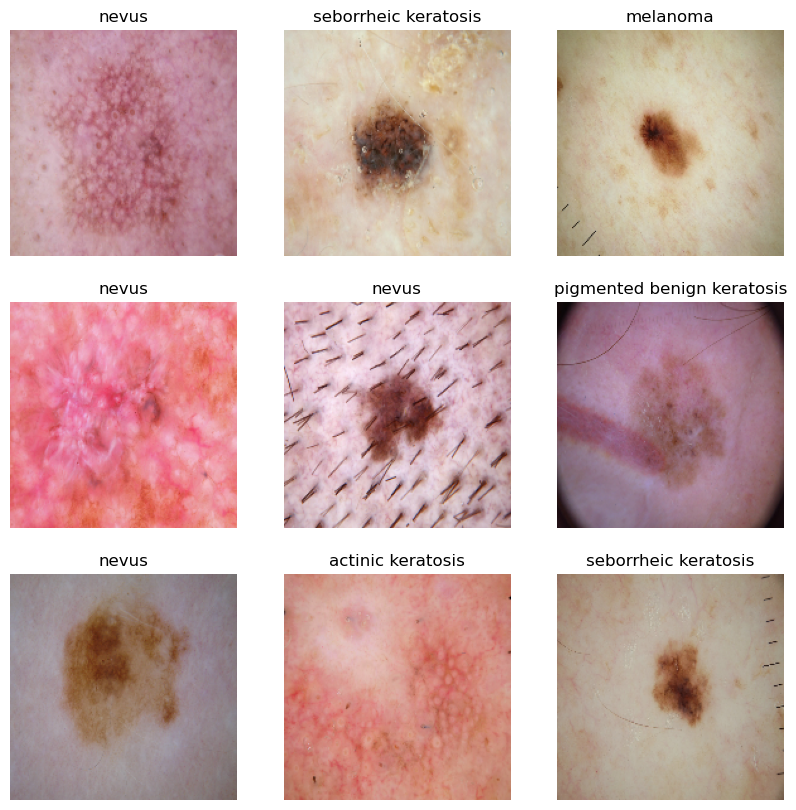

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(2):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create Model

#### Types of models one can use - 
#### CNN Model w/ lesser or more number of convolution layers, w/ Batch Normalization and w/o Dropout Layers

### a. Simple Model - 3 ConvLayers, Kernels at each layer = (16, 32, 64)

In [31]:
num_classes = 9

model_simple = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [32]:
model_simple.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [33]:
epochs = 20
history = model_simple.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=epochs, shuffle=True, batch_size=batch_size
)

Epoch 1/20
56/56 [==============================] - 9s 155ms/step - loss: 2.0457 - accuracy: 0.1987 - val_loss: 2.3458 - val_accuracy: 0.0435
Epoch 2/20
56/56 [==============================] - 9s 158ms/step - loss: 2.0276 - accuracy: 0.2204 - val_loss: 2.4093 - val_accuracy: 0.0435
Epoch 3/20
56/56 [==============================] - 9s 158ms/step - loss: 2.0260 - accuracy: 0.2065 - val_loss: 2.3323 - val_accuracy: 0.1739
Epoch 4/20
56/56 [==============================] - 9s 160ms/step - loss: 2.0277 - accuracy: 0.2015 - val_loss: 2.3888 - val_accuracy: 0.0435
Epoch 5/20
56/56 [==============================] - 9s 160ms/step - loss: 2.0204 - accuracy: 0.2081 - val_loss: 2.3640 - val_accuracy: 0.0435
Epoch 6/20
56/56 [==============================] - 9s 160ms/step - loss: 2.0242 - accuracy: 0.1914 - val_loss: 2.3044 - val_accuracy: 0.1739
Epoch 7/20
56/56 [==============================] - 9s 158ms/step - loss: 2.0261 - accuracy: 0.1959 - val_loss: 2.3589 - val_accuracy: 0.1739
Epoch 

#### Inference - Model training is poor: Just 20% training accuracy and 4% validation accuracy!
#### This cannot be used for image classification - NEED TO ADD MORE LAYERS

### b. Trying of complex model
###      - 4 ConvLayers with BatchNormalization and w/o DropOut Layers
Kernels at each layer = (32, 32, 64, 64); Kernel size = 3x3

In [12]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
valid_ds = valid_ds.map(lambda x, y: (normalization_layer(x), y))

In [14]:
num_classes = 9
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(img_width, img_height, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [15]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [17]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=epochs, shuffle=True, batch_size=batch_size
)

Epoch 1/20
56/56 [==============================] - 162s 3s/step - loss: 3.4130 - accuracy: 0.3488 - val_loss: 4.6905 - val_accuracy: 0.1739
Epoch 2/20
56/56 [==============================] - 143s 3s/step - loss: 1.2757 - accuracy: 0.5569 - val_loss: 5.0049 - val_accuracy: 0.1304
Epoch 3/20
56/56 [==============================] - 156s 3s/step - loss: 0.9071 - accuracy: 0.6702 - val_loss: 6.6484 - val_accuracy: 0.0870
Epoch 4/20
56/56 [==============================] - 147s 3s/step - loss: 0.5555 - accuracy: 0.8036 - val_loss: 5.8456 - val_accuracy: 0.0870
Epoch 5/20
56/56 [==============================] - 144s 3s/step - loss: 0.3453 - accuracy: 0.8750 - val_loss: 5.2812 - val_accuracy: 0.0870
Epoch 6/20
56/56 [==============================] - 91s 2s/step - loss: 0.2086 - accuracy: 0.9235 - val_loss: 5.6555 - val_accuracy: 0.0870
Epoch 7/20
56/56 [==============================] - 63s 1s/step - loss: 0.1573 - accuracy: 0.9431 - val_loss: 4.4431 - val_accuracy: 0.1304
Epoch 8/20
56/5

In [18]:
# View the summary of all layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 activation (Activation)     (None, 180, 180, 32)      0         
                                                                 
 batch_normalization (Batch  (None, 180, 180, 32)      128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 178, 178, 32)      9248      
                                                                 
 activation_1 (Activation)   (None, 178, 178, 32)      0         
                                                                 
 batch_normalization_1 (Bat  (None, 178, 178, 32)      128       
 chNormalization)                                     

### Visualizing training results

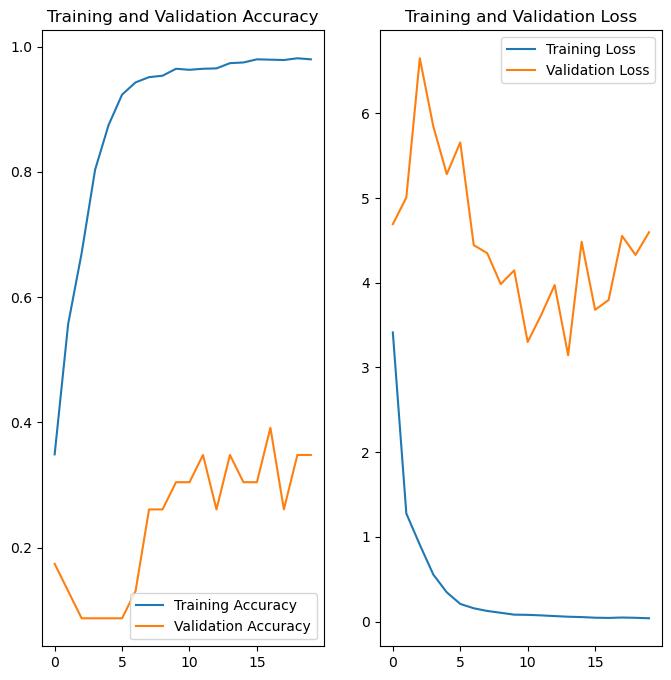

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings

The model is clearly overfitting as after 20 epochs it seems that train_accuracy has reached 0.89 whereas it does poorly with validation set with validation_accuracy of 0.36

### c. Using DropOut layer in the model.b

### Model with DropOut - dropout factor = 0.2 in the DNN layer
### Kernels at each layer = (32, 32, 64, 64); Kernel size = 3x3

In [59]:
num_classes = 9
model_do = Sequential()
model_do.add(Conv2D(32, (3, 3), padding='same', input_shape=(img_width, img_height, 3)))
model_do.add(Activation('relu'))
model_do.add(BatchNormalization())
model_do.add(Conv2D(32, (3, 3)))
model_do.add(Activation('relu'))
model_do.add(BatchNormalization())
model_do.add(MaxPooling2D(pool_size=(2, 2)))
#model_do.add(Dropout(0.25))

model_do.add(Conv2D(64, (3, 3), padding='same'))
model_do.add(Activation('relu'))
model_do.add(BatchNormalization())
model_do.add(Conv2D(64, (3, 3)))
model_do.add(Activation('relu'))
model_do.add(BatchNormalization())
model_do.add(MaxPooling2D(pool_size=(2, 2)))
#model_do.add(Dropout(0.25))

model_do.add(Flatten())
model_do.add(Dense(512))
model_do.add(Activation('relu'))
model_do.add(Dropout(0.2))
model_do.add(Dense(num_classes))
model_do.add(Activation('softmax'))

In [60]:
model_do.compile(loss='sparse_categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [61]:
epochs = 20
history = model_do.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=epochs, shuffle=True, batch_size=batch_size
)

Epoch 1/20
56/56 [==============================] - 57s 1s/step - loss: 3.2460 - accuracy: 0.3158 - val_loss: 2.7092 - val_accuracy: 0.2609
Epoch 2/20
56/56 [==============================] - 61s 1s/step - loss: 1.4281 - accuracy: 0.4877 - val_loss: 4.7205 - val_accuracy: 0.0870
Epoch 3/20
56/56 [==============================] - 66s 1s/step - loss: 1.1199 - accuracy: 0.5820 - val_loss: 4.6726 - val_accuracy: 0.1739
Epoch 4/20
56/56 [==============================] - 64s 1s/step - loss: 0.8624 - accuracy: 0.6858 - val_loss: 4.8894 - val_accuracy: 0.0435
Epoch 5/20
56/56 [==============================] - 66s 1s/step - loss: 0.6486 - accuracy: 0.7667 - val_loss: 5.7816 - val_accuracy: 0.1304
Epoch 6/20
56/56 [==============================] - 66s 1s/step - loss: 0.4452 - accuracy: 0.8365 - val_loss: 3.6333 - val_accuracy: 0.1739
Epoch 7/20
56/56 [==============================] - 65s 1s/step - loss: 0.3385 - accuracy: 0.8800 - val_loss: 4.2304 - val_accuracy: 0.2609
Epoch 8/20
56/56 [==

### d. Try out model with more layers w/ dropouts
###  6 ConvLayers with dropout factors = 0.25 at every ConvLayer and 0.5 at the final DNN layer
###  Kernels at each layer = (32, 32, 64, 64, 128, 128); Kernel size = 3x3

In [64]:
model_ml = Sequential()
model_ml.add(Conv2D(32, (3, 3), padding='same', input_shape=(img_width, img_height, 3)))
model_ml.add(Activation('relu'))
model_ml.add(BatchNormalization())
model_ml.add(Conv2D(32, (3, 3)))
model_ml.add(Activation('relu'))
model_ml.add(BatchNormalization())
model_ml.add(MaxPooling2D(pool_size=(2, 2)))
model_ml.add(Dropout(0.25))

model_ml.add(Conv2D(64, (3, 3), padding='same'))
model_ml.add(Activation('relu'))
model_ml.add(BatchNormalization())
model_ml.add(Conv2D(64, (3, 3)))
model_ml.add(Activation('relu'))
model_ml.add(BatchNormalization())
model_ml.add(MaxPooling2D(pool_size=(2, 2)))
model_ml.add(Dropout(0.25))

model_ml.add(Conv2D(128, (3, 3), padding='same'))
model_ml.add(Activation('relu'))
model_ml.add(BatchNormalization())
model_ml.add(Conv2D(128, (3, 3)))
model_ml.add(Activation('relu'))
model_ml.add(BatchNormalization())
model_ml.add(MaxPooling2D(pool_size=(2, 2)))
model_ml.add(Dropout(0.25))

model_ml.add(Flatten())
model_ml.add(Dense(512,kernel_regularizer=l2(0.01)))
model_ml.add(Activation('relu'))
model_ml.add(Dropout(0.5))
model_ml.add(Dense(num_classes))
model_ml.add(Activation('softmax'))

In [65]:
model_ml.compile(loss='sparse_categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [66]:
epochs = 20
history_ml = model_ml.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=epochs, shuffle=True, batch_size=batch_size
)

Epoch 1/20
56/56 [==============================] - 70s 1s/step - loss: 14.6879 - accuracy: 0.2946 - val_loss: 13.8354 - val_accuracy: 0.0870
Epoch 2/20
56/56 [==============================] - 79s 1s/step - loss: 11.5131 - accuracy: 0.4408 - val_loss: 15.8813 - val_accuracy: 0.0870
Epoch 3/20
56/56 [==============================] - 80s 1s/step - loss: 11.1091 - accuracy: 0.5223 - val_loss: 17.9864 - val_accuracy: 0.0870
Epoch 4/20
56/56 [==============================] - 81s 1s/step - loss: 10.7837 - accuracy: 0.5385 - val_loss: 18.5716 - val_accuracy: 0.0870
Epoch 5/20
56/56 [==============================] - 82s 1s/step - loss: 10.4790 - accuracy: 0.5809 - val_loss: 18.9584 - val_accuracy: 0.0870
Epoch 6/20
56/56 [==============================] - 82s 1s/step - loss: 10.1993 - accuracy: 0.6049 - val_loss: 15.6163 - val_accuracy: 0.0435
Epoch 7/20
56/56 [==============================] - 86s 2s/step - loss: 9.8802 - accuracy: 0.6445 - val_loss: 14.4405 - val_accuracy: 0.0435
Epoch 8

### > Inference - Even with the model with more number of convolution layers, the validation accuracy is not that good - about 0.3

### Distribution of classes in the files

<Figure size 3000x800 with 0 Axes>

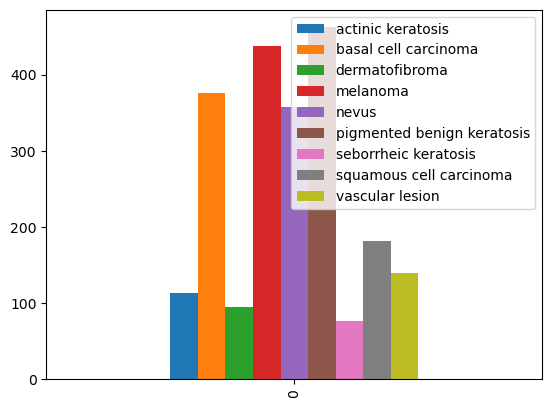

In [58]:
image_ct_dict = {}
for c_name in class_names:
    image_ct_dict[c_name] = len(list(data_dir_train.glob(c_name + '/*.jpg')))

df = pd.DataFrame([image_ct_dict])
plt.figure(figsize=(30, 8))
df.plot.bar()
plt.show()

### It can be observed from the distribution plot that "Melanoma" and "Pigmented benign keratosis" has most number of images available. This is the reason the model tends to overfit all the time

## Augmentor approach

### Solution to improve model accuracy on validation dataset is to perform augmentation i.e. add more number of samples to the classes that have lesser training data samples

In [73]:
path_to_training_dataset = str(data_dir_train) + "/"
print(path_to_training_dataset)
# Instantiate a Pipeline object pointing to a directory containing your initial image data set.
# Define a number of operations to perform on this data set using your Pipeline object.
# Execute these operations by calling the Pipeline’s sample() method.
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Skin cancer ISIC The International Skin Imaging Collaboration/Train/
Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2D09A3710>: 100%|█|


Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2D0A83B50>: 100%|█|


Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x2


Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=962x674 at 0x2


Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2D09AF590>: 100%|█|


Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2D0990DD0>: 100%|█|


Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x2C4650110>: 100%|█


Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2D099FDD0>: 100%|█|


Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2D09B7750>: 100%|█|


In [74]:
image_count_train = len(list(data_dir_train.glob(*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [80]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010555.jpg_ceec0305-b54e-420e-b5c4-3a0606e415e0.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0011178.jpg_deeca595-ffce-403f-8bda-f189ff52a4bf.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000405.jpg_e0c47ceb-39ea-41c5-bd90-f0d171fbc78d.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000299.jpg_7c0cf678-4c46-4f26-af10-489812e6e7f1.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010737.jpg_1165bd66-1026-4e3c-bff5-2ce3532d5ab5.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0001143.jpg_4d5a42bb-9c77-46a4-b60c-a6beedc9f09c.jpg',
 'Skin cancer IS

In [81]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [83]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [95]:
dataframe_dict_new

{'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010555.jpg_ceec0305-b54e-420e-b5c4-3a0606e415e0.jpg': 'melanoma',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0011178.jpg_deeca595-ffce-403f-8bda-f189ff52a4bf.jpg': 'melanoma',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000405.jpg_e0c47ceb-39ea-41c5-bd90-f0d171fbc78d.jpg': 'melanoma',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000299.jpg_7c0cf678-4c46-4f26-af10-489812e6e7f1.jpg': 'melanoma',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010737.jpg_1165bd66-1026-4e3c-bff5-2ce3532d5ab5.jpg': 'melanoma',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0001143.jpg

In [98]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])

In [99]:
df2['Label'].value_counts()

melanoma                      500
pigmented benign keratosis    500
nevus                         500
basal cell carcinoma          500
actinic keratosis             500
squamous cell carcinoma       500
vascular lesion               500
seborrheic keratosis          500
dermatofibroma                500
Name: Label, dtype: int64

#### So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

### Train the model on the data created using Augmentor

In [87]:
data_dir_train_aug= data_dir_train
train_ds_aug = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train_aug,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [88]:
valid_ds_aug = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train_aug,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


### Model considering augmented data as well

In [89]:
model_ml_aug = Sequential()
model_ml_aug.add(Conv2D(32, (3, 3), padding='same', input_shape=(img_width, img_height, 3)))
model_ml_aug.add(Activation('relu'))
model_ml_aug.add(BatchNormalization())
model_ml_aug.add(Conv2D(32, (3, 3)))
model_ml_aug.add(Activation('relu'))
model_ml_aug.add(BatchNormalization())
model_ml_aug.add(MaxPooling2D(pool_size=(2, 2)))
model_ml_aug.add(Dropout(0.25))

model_ml_aug.add(Conv2D(64, (3, 3), padding='same'))
model_ml_aug.add(Activation('relu'))
model_ml_aug.add(BatchNormalization())
model_ml_aug.add(Conv2D(64, (3, 3)))
model_ml_aug.add(Activation('relu'))
model_ml_aug.add(BatchNormalization())
model_ml_aug.add(MaxPooling2D(pool_size=(2, 2)))
model_ml_aug.add(Dropout(0.25))

model_ml_aug.add(Conv2D(128, (3, 3), padding='same'))
model_ml_aug.add(Activation('relu'))
model_ml_aug.add(BatchNormalization())
model_ml_aug.add(Conv2D(128, (3, 3)))
model_ml_aug.add(Activation('relu'))
model_ml_aug.add(BatchNormalization())
model_ml_aug.add(MaxPooling2D(pool_size=(2, 2)))
model_ml_aug.add(Dropout(0.25))

model_ml_aug.add(Flatten())
model_ml_aug.add(Dense(512,kernel_regularizer=l2(0.01)))
model_ml_aug.add(Activation('relu'))
model_ml_aug.add(Dropout(0.5))
model_ml_aug.add(Dense(num_classes))
model_ml_aug.add(Activation('softmax'))

In [90]:
model_ml_aug.compile(loss='sparse_categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [91]:
epochs = 20
history_ml_aug = model_ml_aug.fit(
  train_ds_aug,
  validation_data=valid_ds_aug,
  epochs=epochs, shuffle=True, batch_size=batch_size
)

Epoch 1/20
169/169 [==============================] - 239s 1s/step - loss: 12.4244 - accuracy: 0.3333 - val_loss: 12.5353 - val_accuracy: 0.2910
Epoch 2/20
169/169 [==============================] - 263s 2s/step - loss: 10.7251 - accuracy: 0.4726 - val_loss: 10.8006 - val_accuracy: 0.4729
Epoch 3/20
169/169 [==============================] - 269s 2s/step - loss: 9.9192 - accuracy: 0.5582 - val_loss: 9.7009 - val_accuracy: 0.5991
Epoch 4/20
169/169 [==============================] - 270s 2s/step - loss: 9.2258 - accuracy: 0.6144 - val_loss: 10.1589 - val_accuracy: 0.4610
Epoch 5/20
169/169 [==============================] - 269s 2s/step - loss: 8.5767 - accuracy: 0.6736 - val_loss: 9.4014 - val_accuracy: 0.5004
Epoch 6/20
169/169 [==============================] - 270s 2s/step - loss: 8.0228 - accuracy: 0.7075 - val_loss: 8.1576 - val_accuracy: 0.6251
Epoch 7/20
169/169 [==============================] - 277s 2s/step - loss: 7.4733 - accuracy: 0.7504 - val_loss: 7.4432 - val_accuracy: 0

In [101]:
model_ml_aug.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_37 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 activation_38 (Activation)  (None, 180, 180, 32)      0         
                                                                 
 batch_normalization_28 (Ba  (None, 180, 180, 32)      128       
 tchNormalization)                                               
                                                                 
 conv2d_38 (Conv2D)          (None, 178, 178, 32)      9248      
                                                                 
 activation_39 (Activation)  (None, 178, 178, 32)      0         
                                                                 
 batch_normalization_29 (Ba  (None, 178, 178, 32)      128       
 tchNormalization)                                   

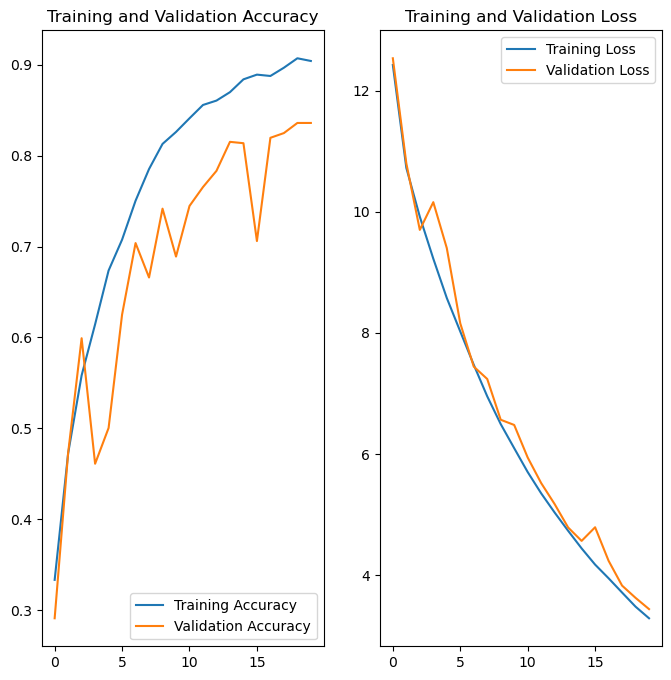

In [93]:
acc_aug = history_ml_aug.history['accuracy']
val_acc_aug = history_ml_aug.history['val_accuracy']

loss_aug = history_ml_aug.history['loss']
val_loss_aug = history_ml_aug.history['val_loss']

epochs_range_aug = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range_aug, acc_aug, label='Training Accuracy')
plt.plot(epochs_range_aug, val_acc_aug, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range_aug, loss_aug, label='Training Loss')
plt.plot(epochs_range_aug, val_loss_aug, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Conclusion

#### 1. Overfitting is seen when the data was imbalanced
#### 2. After applying Augmentation, the model is well trained

### More details:

### A. With imbalanced data - 
#### 1. Model.a: training_acc = 20%, validation_acc = 4% --> clear case of underfitting
#### 2. Model.b: training_acc = 98%, validation_acc = 34% --> clear case of overfitting
#### 3. Model.c: trianing_acc = 96%, validation_acc = 21% --> clear case of overfitting
NOTE: Model.c has an additional dropout layer at the DNN layer. Validation accuracies differ by 13% which can be easily brought down/improved by playing around with dropout factors and adding additional dropout layers at ConvLayers.
#### 4. Model.d: training_acc = training_acc = 89%, validation_acc = 30%
NOTE: Model.d has more number of layers with intermediate dropout layers in the ConvLayers at one at the DNN

Some inference : _Hence, it can be seen that Adding more layers with additional dropout layers does not improve the performance drastically BUT CERTAINLY TAKES LESSER TIME TO TRAIN!_

### B. With Augmentation included - data balancing
####      Model.d is used with augmented data
###      training_acc = 90%, validation_acc = 84% --> This is pretty good. Problem of overfitting is solved!